<h2><font size="3" color="#008B8B"><strong>Principais objetivos: </strong></font></h2>
<ul>
    <li><font size="2" color="#1f77b4">Orgarnizar dados para series temporais.</font></li>
    <li><font size="2" color="#1f77b4">Definir frequencia dos dados.</font></li>
    <li><font size="2" color="#1f77b4">Remover valores discrepantes (outliers).</font></li>
    <li><font size="2" color="#1f77b4">Verificar valores ausentes (missing values)..</font></li>
    <li><font size="2" color="#1f77b4">Interpolar valores ausentes.</font></li>
    <li><font size="2" color="#1f77b4">Reamostrar os dados (resamples);.</font></li>
    <li><font size="2" color="#1f77b4">Salvar em arquivos .csv as reamostras.</font></li>
</ul>

In [37]:
import pandas as pd
import numpy as np
import pytz

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

SAVE_FIGURE = True

In [38]:
# Constants:

BR_TZ = pytz.timezone("America/Sao_Paulo")
UTC_TZ = pytz.timezone("UTC")
FMT = "%Y-%m-%d %H:%M:%S"
FREQUENCY = "H"

START_DATE = "2023-06-01 00:00:00"  # UTC -3
END_DATE = "2024-06-30 23:59:59"    # UTC -3

In [39]:
# jupter notebook settings

sns.set_context("talk")

dark_orange = "#FF8C00"
dark_blue = "#00008B"
dark_green = "#006400"
dark_cyan = "#008B8B"
dark_slate = "#2F4F4F"
dark_magenta = "#8B008B"
dark_red = "#8B0000"
dark_olive = "#556B2F"
crimson = "#DC143C"

yellow_green = "#9ACD32"
lime_green = "#32CD32"
lime = "#00FF00"
gold = "#FFD700"
golden_rod = "#DAA520"
dark_golden_rod = "#B8860B"
light_blue = "#AED6F1"
light_red = "#F1948A"
highlight_green = "green"
highlight_red = "red"


color_ldtea = sns.color_palette("tab10")[2]  # 
dark_color_ldtea = sns.color_palette("Greens")[4]  # Verde escuro
color_uac = sns.color_palette("tab10")[0]  # Azul
dark_color_uac = sns.color_palette("Blues")[4]  # Azul escuro


In [40]:
# Funções auxiliares

def calculate_iqr(data, factor=1.5, interval="daily"):
    if interval == "daily":
        data = data.between_time('06:00', '18:00')
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    lower_bound = max(lower_bound, 0)
    return lower_bound, upper_bound

def filter_outliers(group, col, factor):
    lower_bound, upper_bound = calculate_iqr(group[col], factor)
    print("=" * 40)
    print(f"building: {group['building'].iloc[0]}")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    not_outliers_mask = (group[col] >= lower_bound) & (group[col] <= upper_bound)
    outliers_mask = ~not_outliers_mask
    return group[not_outliers_mask], group[outliers_mask]


def remove_outliers_df(df, column, factor=1.5):
    filtered_groups = []
    outlier_groups = []

    for _, group in df.groupby("transductor_id"):
        filtered_group, outlier_group = filter_outliers(group, column, factor)
        filtered_groups.append(filtered_group)
        outlier_groups.append(outlier_group)

    df_filtered = pd.concat(filtered_groups)
    df_outliers = pd.concat(outlier_groups)
    return df_filtered, df_outliers


def create_building_name(df):
    new_df = df.copy()
    new_df["building"] = new_df["building"] + "_" + new_df["transductor_id"].astype(str)
    new_df.drop(columns=["transductor_id"], inplace=True)
    return new_df


def align_resample(data, freq, offset="1s"):
    df = data.copy()
    df.index = df.index - pd.Timedelta(offset)
    
    df_resampled = df.resample(freq).sum()
    return df_resampled.round(2)

In [41]:
# Funções auxiliares gerar gráficos

# sns.set_style("darkgrid")
def plot_column(data, ax_box, ax_hist, col_name, factor=1.5):
    lower_bound, upper_bound = calculate_iqr(data, factor)

    sns.boxplot(x=data, ax=ax_box, color=sns.color_palette("cool")[0])
    ax_box.axes.get_xaxis().set_visible(False)
    ax_box.axes.get_yaxis().set_visible(False)
    ax_box.set_title(f"{col_name.upper()}", fontweight="bold", fontsize=14, pad=10)

    sns.histplot(
        x=data,
        ax=ax_hist,
        color=sns.color_palette("cool")[2],
        label=col_name,
        kde=True,
        bins=30,
    )
    ax_hist.axvline(-0.03, 0, ax_hist.get_ylim()[1], color="r", linestyle="dashed")
    ax_hist.axvline(upper_bound, 0, ax_hist.get_ylim()[1], color="r", linestyle="dashed")


    ax_hist.annotate(
        f"limite superior: {upper_bound:.2f}",
        xy=(upper_bound, ax_hist.get_ylim()[1] * 0.55),
        xytext=(upper_bound - 2.8, ax_hist.get_ylim()[1] * 0.8),
        arrowprops=dict(arrowstyle="->", color="black"),
        fontsize=11,
    )

    ax_hist.annotate(
        f"limite inferior: {0:.2f}",
        xy=(lower_bound, ax_hist.get_ylim()[1] * 0.55),
        xytext=(lower_bound + 0.7, ax_hist.get_ylim()[1] * 0.8),
        arrowprops=dict(arrowstyle="->", color="black"),
        fontsize=11,
    )

    ax_hist.legend(fontsize=10)
    ax_hist.grid(axis="y", linestyle="--", lw=0.5)
    ax_hist.set_xlabel(" ", labelpad=15)
    ax_hist.set_ylabel(" ", labelpad=15)
    ax_hist.set_xticklabels(ax_hist.get_xticklabels(), fontsize=13)
    ax_hist.set_yticklabels(ax_hist.get_yticklabels(), fontsize=13)
    sns.despine()


def plot_columns(df, outliers, factor=1.7):
    num_cols = len(df.columns)

    if num_cols != 6:
        raise ValueError("The provided dataframe should have 6 columns for this function.")

    f, axes = plt.subplots(6, 2, gridspec_kw={"height_ratios": [0.09, 0.7] * 3}, figsize=[20, 3 * num_cols])

    for idx, col in enumerate(df.columns):
        col_idx = idx // 3
        row_idx = 2 * (idx % 3)
        ax_box = axes[row_idx, col_idx]
        ax_hist = axes[row_idx + 1, col_idx]
        plot_column(df[col], ax_box, ax_hist, col, factor)

    plt.tight_layout()
    plt.suptitle("Análise de dispersão e detecção de Outliers(LDTEA e UAC) ", fontsize=18, y=1.05)
    if SAVE_FIGURE:
        file_path = (
            "../figures/data_preparation/0.6_analysis_outliers_boxplot_and_hist_h.pdf"
            if outliers
            else "../figures/data_preparation/0.6_analysis_no_outliers_boxplot_and_hist_h.pdf"
        )
        plt.savefig(file_path, dpi=300)
    plt.show()

# ------------------------------------------------------------------------------------------------------------------

def plot_columns_mid(df, outliers, factor=1.7):
    num_cols = len(df.columns)
    num_rows = int(np.ceil(num_cols / 3))

    fig, axes = plt.subplots(
        num_rows * 2,
        3,
        figsize=[18, 4.5 * num_rows],
        gridspec_kw={"height_ratios": [0.25, 0.85] * num_rows},
    )

    for i, col in enumerate(df.columns):
        lower_bound, upper_bound = calculate_iqr(df[col], factor)

        row_idx = 2 * (i // 3)
        col_idx = i % 3
        ax_box = axes[row_idx, col_idx]
        ax_hist = axes[row_idx + 1, col_idx]

        sns.boxplot(x=df[col], ax=ax_box, color="lightblue")
        ax_box.axes.get_xaxis().set_visible(False)
        ax_box.axes.get_yaxis().set_visible(False)
        ax_box.set_title(f"{col.upper()}", fontweight="bold", fontsize=12)

        sns.histplot(x=df[col], ax=ax_hist, color="skyblue", label=col, kde=True)
        ax_hist.vlines(
            0, 0, ax_hist.get_ylim()[1] * 0.8, color="r", linestyles="dashed"
        )
        ax_hist.vlines(
            upper_bound,
            lower_bound,
            ax_hist.get_ylim()[1] * 0.8,
            color="r",
            linestyles="dashed",
        )
        ax_hist.grid(axis="y", linestyle="--", lw=0.5)
        ax_hist.set_xlabel(" ")
        ax_hist.set_ylabel(" ")
        ax_hist.set_xticklabels(ax_hist.get_xticklabels(), fontsize=10)
        ax_hist.set_yticklabels(ax_hist.get_yticklabels(), fontsize=10)

    for j in range(num_cols, num_rows * 3):
        axes[j // 3 * 2, j % 3].axis("off")
        axes[j // 3 * 2 + 1, j % 3].axis("off")

    sns.despine()
    plt.tight_layout()
    plt.tight_layout()
    plt.suptitle("Análise de dispersão e detecção de Outliers (LDTEA e UAC) ", fontsize=18, y=1.05)
    plt.suptitle("Análise de dispersão e detecção de Outliers(LDTEA e UAC) ", fontsize=18, y=1.05)
    if SAVE_FIGURE:
        file_path = (
            "../figures/data_preparation/0.6_analysis_outliers_boxplot_and_hist_v.pdf"
            if outliers
            else "../figures/data_preparation/0.6_analysis_no_outliers_boxplot_and_hist_v.pdf"
        )
        plt.savefig(file_path, dpi=300)
    plt.show()


In [42]:
file_path = "../data/clean/0.0_production_sige_pt15m_pre.csv"

raw_df = pd.read_csv(file_path, index_col="date_time", parse_dates=True)
raw_df

active_generated  is_calculated  transductor_id  \
date_time                                                                    
2023-05-29 21:15:00-03:00              0.00          False               1   
2023-05-29 21:30:00-03:00              0.00          False               1   
2023-05-29 21:45:00-03:00              0.00          False               1   
2023-05-29 22:00:00-03:00              0.00          False               1   
2023-05-29 22:15:00-03:00              0.00          False               1   
...                                     ...            ...             ...   
2024-07-06 07:15:00-03:00              0.08          False               8   
2024-07-06 07:30:00-03:00              0.09          False               8   
2024-07-06 07:45:00-03:00              0.13          False               8   
2024-07-06 08:00:00-03:00              0.15          False               8   
2024-07-06 08:15:00-03:00              0.18          False               8   

                          building  
date_time                           
2023-05-29 21:15:00-03:00      UAC  
2023-05-29 21:30:00-03:00      UAC  
2023-05-29 21:45:00-03:00      UAC  
2023-05-29 22:00:00-03:00      UAC  
2023-05-29 22:15:00-03:00      UAC  
...                            ...  
2024-07-06 07:15:00-03:00    LDTEA  
2024-07-06 07:30:00-03:00    LDTEA  
2024-07-06 07:45:00-03:00    LDTEA  
2024-07-06 08:00:00-03:00    LDTEA  
2024-07-06 08:15:00-03:00    LDTEA  

[232096 rows x 4 columns]

In [43]:
# Deletar registros calculados

# registros calculados (is_calculated = False)
# collected_df = raw_df[~raw_df["is_calculated"]]  

# Deletar a coluna is_calculated nao é mais necessária
collected_df = raw_df.copy()
collected_df.drop(columns=["is_calculated"], inplace=True)

display(f"Shape raw_df      : {raw_df.shape}")
display(f"Shape collected_df: {collected_df.shape}")
display(collected_df)

'Shape raw_df      : (232096, 4)'

'Shape collected_df: (232096, 3)'

active_generated  transductor_id building
date_time                                                           
2023-05-29 21:15:00-03:00              0.00               1      UAC
2023-05-29 21:30:00-03:00              0.00               1      UAC
2023-05-29 21:45:00-03:00              0.00               1      UAC
2023-05-29 22:00:00-03:00              0.00               1      UAC
2023-05-29 22:15:00-03:00              0.00               1      UAC
...                                     ...             ...      ...
2024-07-06 07:15:00-03:00              0.08               8    LDTEA
2024-07-06 07:30:00-03:00              0.09               8    LDTEA
2024-07-06 07:45:00-03:00              0.13               8    LDTEA
2024-07-06 08:00:00-03:00              0.15               8    LDTEA
2024-07-06 08:15:00-03:00              0.18               8    LDTEA

[232096 rows x 3 columns]

In [44]:
# Removendo outliers usando IQR

cleaned_df, outliers_df = remove_outliers_df(collected_df, "active_generated", 1)
cleaned_df = cleaned_df.sort_index()
df = cleaned_df.copy()

display(f"df (com outliers): {collected_df.shape[0]}")
display(f"clean_df (sem outliers): {df.shape[0]}")
display(f"Outliers removidos: {collected_df.shape[0] - df.shape[0]}")
df

building: UAC
Lower bound: 0, Upper bound: 9.45
building: UAC
Lower bound: 0, Upper bound: 10.670000000000002
building: LDTEA
Lower bound: 0, Upper bound: 7.77
building: LDTEA
Lower bound: 0, Upper bound: 7.7299999999999995
building: LDTEA
Lower bound: 0, Upper bound: 7.51
building: LDTEA
Lower bound: 0, Upper bound: 7.12


'df (com outliers): 232096'

'clean_df (sem outliers): 231922'

'Outliers removidos: 174'

active_generated  transductor_id building
date_time                                                           
2023-05-29 21:15:00-03:00              0.00               1      UAC
2023-05-29 21:30:00-03:00              0.00               2      UAC
2023-05-29 21:30:00-03:00              0.00               1      UAC
2023-05-29 21:45:00-03:00              0.00               1      UAC
2023-05-29 21:45:00-03:00              0.00               5    LDTEA
...                                     ...             ...      ...
2024-07-06 08:00:00-03:00              2.01               6    LDTEA
2024-07-06 08:00:00-03:00              1.76               1      UAC
2024-07-06 08:15:00-03:00              1.16               7    LDTEA
2024-07-06 08:15:00-03:00              2.39               6    LDTEA
2024-07-06 08:15:00-03:00              0.18               8    LDTEA

[231922 rows x 3 columns]

In [45]:
# Pivotando os DataFrames e definir frequência dos dados

nraw_df = create_building_name(raw_df)
praw_df = nraw_df.pivot_table(
    index="date_time",
    columns="building",
    values="active_generated",
)
display(f"raw shape: {nraw_df.shape[0]} ===> {praw_df.shape[0]}")

noutliers_df = create_building_name(outliers_df)
poutliers_df = noutliers_df.pivot_table(
    index="date_time",
    columns="building",
    values="active_generated",
)
display(f"outliers shape: {noutliers_df.shape[0]} ===> {poutliers_df.shape[0]}")

ndf = create_building_name(df)
pivot_df = ndf.pivot_table(
    index="date_time",
    columns="building",
    values="active_generated",
)
display(f"df shape: {df.shape[0]}  ===> {pivot_df.shape[0]}")
base_df = pivot_df.asfreq("15T")
display(f"df shape: {df.shape[0]}  ===> {pivot_df.shape[0]}")
display(f"15T shape: {pivot_df.shape[0]}")
display(f"freq : {pivot_df.index.freq} ===> {base_df.index.freq}")
base_df

'raw shape: 232096 ===> 38727'

'outliers shape: 174 ===> 64'

'df shape: 231922  ===> 38727'

'df shape: 231922  ===> 38727'

'15T shape: 38727'

'freq : None ===> <15 * Minutes>'

building                   LDTEA_5  LDTEA_6  LDTEA_7  LDTEA_8  UAC_1  UAC_2
date_time                                                                  
2023-05-29 21:15:00-03:00      NaN      NaN      NaN      NaN   0.00    NaN
2023-05-29 21:30:00-03:00      NaN      NaN      NaN      NaN   0.00   0.00
2023-05-29 21:45:00-03:00     0.00     0.00     0.00     0.00   0.00   0.00
2023-05-29 22:00:00-03:00     0.00     0.00     0.00     0.00   0.00   0.00
2023-05-29 22:15:00-03:00     0.00     0.00     0.00     0.00   0.00   0.00
...                            ...      ...      ...      ...    ...    ...
2024-07-06 07:15:00-03:00     0.75     0.75     0.36     0.08   0.41   0.35
2024-07-06 07:30:00-03:00     1.19     1.19     0.58     0.09   0.86   0.91
2024-07-06 07:45:00-03:00     1.63     1.62     0.77     0.13   1.30   1.44
2024-07-06 08:00:00-03:00     2.02     2.01     0.94     0.15   1.76   1.97
2024-07-06 08:15:00-03:00      NaN     2.39     1.16     0.18    NaN    NaN

[38733 rows x 6 columns]

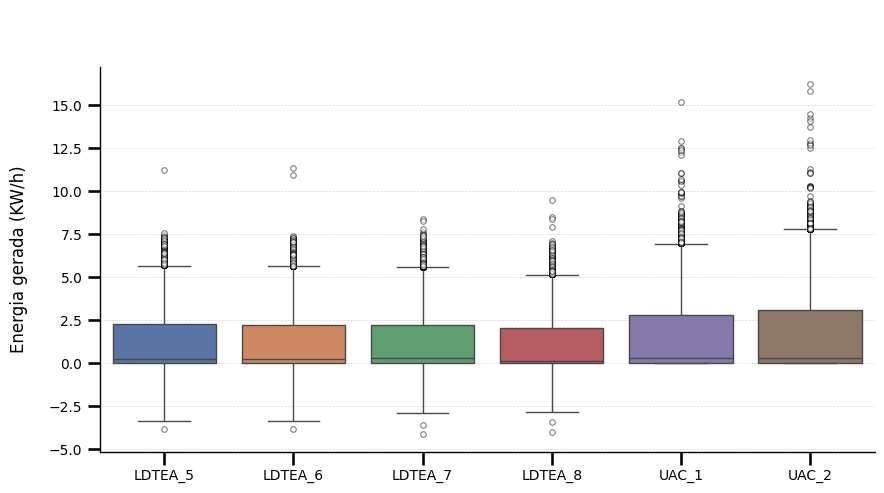

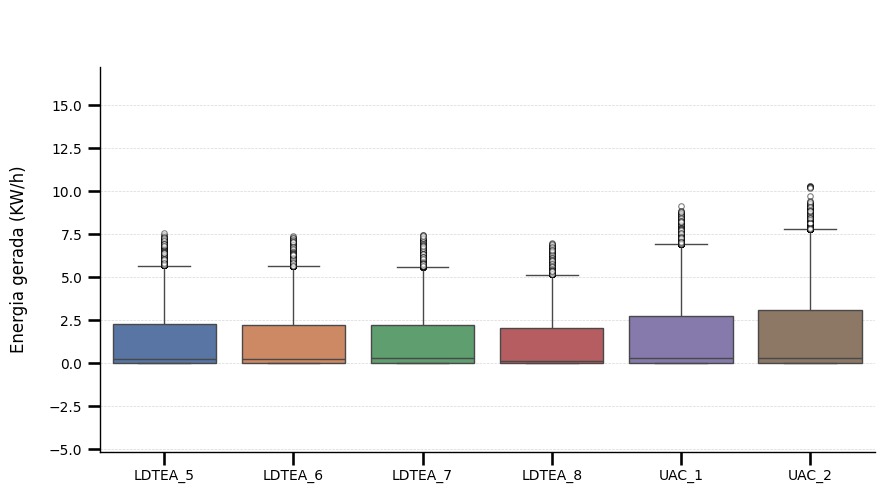

In [46]:
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.boxplot(
    data=praw_df,
    ax=ax1,
    palette="deep",
    showfliers=True,
    flierprops=dict(
        marker="o",
        markersize=4,
        markeredgecolor="black",
        markerfacecolor="white",
        markeredgewidth=0.8,
        alpha=0.5,
    ),
)
ax1.set_title("Distribuição de geração de energia por medidor (com outliers)", fontsize=14, pad=30)
ax1.set_title(" ", fontsize=14, pad=30)
ax1.set_ylabel("Energia gerada (KW/h)", fontsize=12, labelpad=15)
ax1.set_xlabel("")
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)
ax1.spines["left"].set_linewidth(1)
ax1.spines["bottom"].set_linewidth(1)
ax1.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.5)
ylim1 = ax1.get_ylim()
sns.despine(ax=ax1)

if SAVE_FIGURE:
    plt.savefig(
        "../figures/data_preparation/0.6_distribution_boxplot_outliers.pdf",
        dpi=300,
        bbox_inches="tight",
        # transparent=True,
    )

fig, ax2 = plt.subplots(figsize=(10, 5))
sns.boxplot(
    data=base_df,
    ax=ax2,
    palette="deep",
    showfliers=True,
    flierprops=dict(
        marker="o",
        markersize=4,
        markeredgecolor="black",
        markerfacecolor="white",
        markeredgewidth=0.8,
        alpha=0.5,
    ),
)
ax2.set_title("Distribuição de geração de energia por medidor (sem outliers)", fontsize=14, pad=30)
ax2.set_title(" ", fontsize=14, pad=30)
ax2.set_ylim(ylim1)
ax2.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.5)
ax2.set_xlabel("")
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=10)
ax2.set_ylabel("Energia gerada (KW/h)", fontsize=12, labelpad=15)
ax2.spines["left"].set_linewidth(1)
ax2.spines["bottom"].set_linewidth(1)
sns.despine(ax=ax2)
ylim2 = ax2.get_ylim()


if SAVE_FIGURE:
    plt.savefig(
        "../figures/data_preparation/0.6_distribution_boxplot_no_outliers.pdf",
        dpi=300,
        bbox_inches="tight",
        # transparent=True,
    )
plt.show()

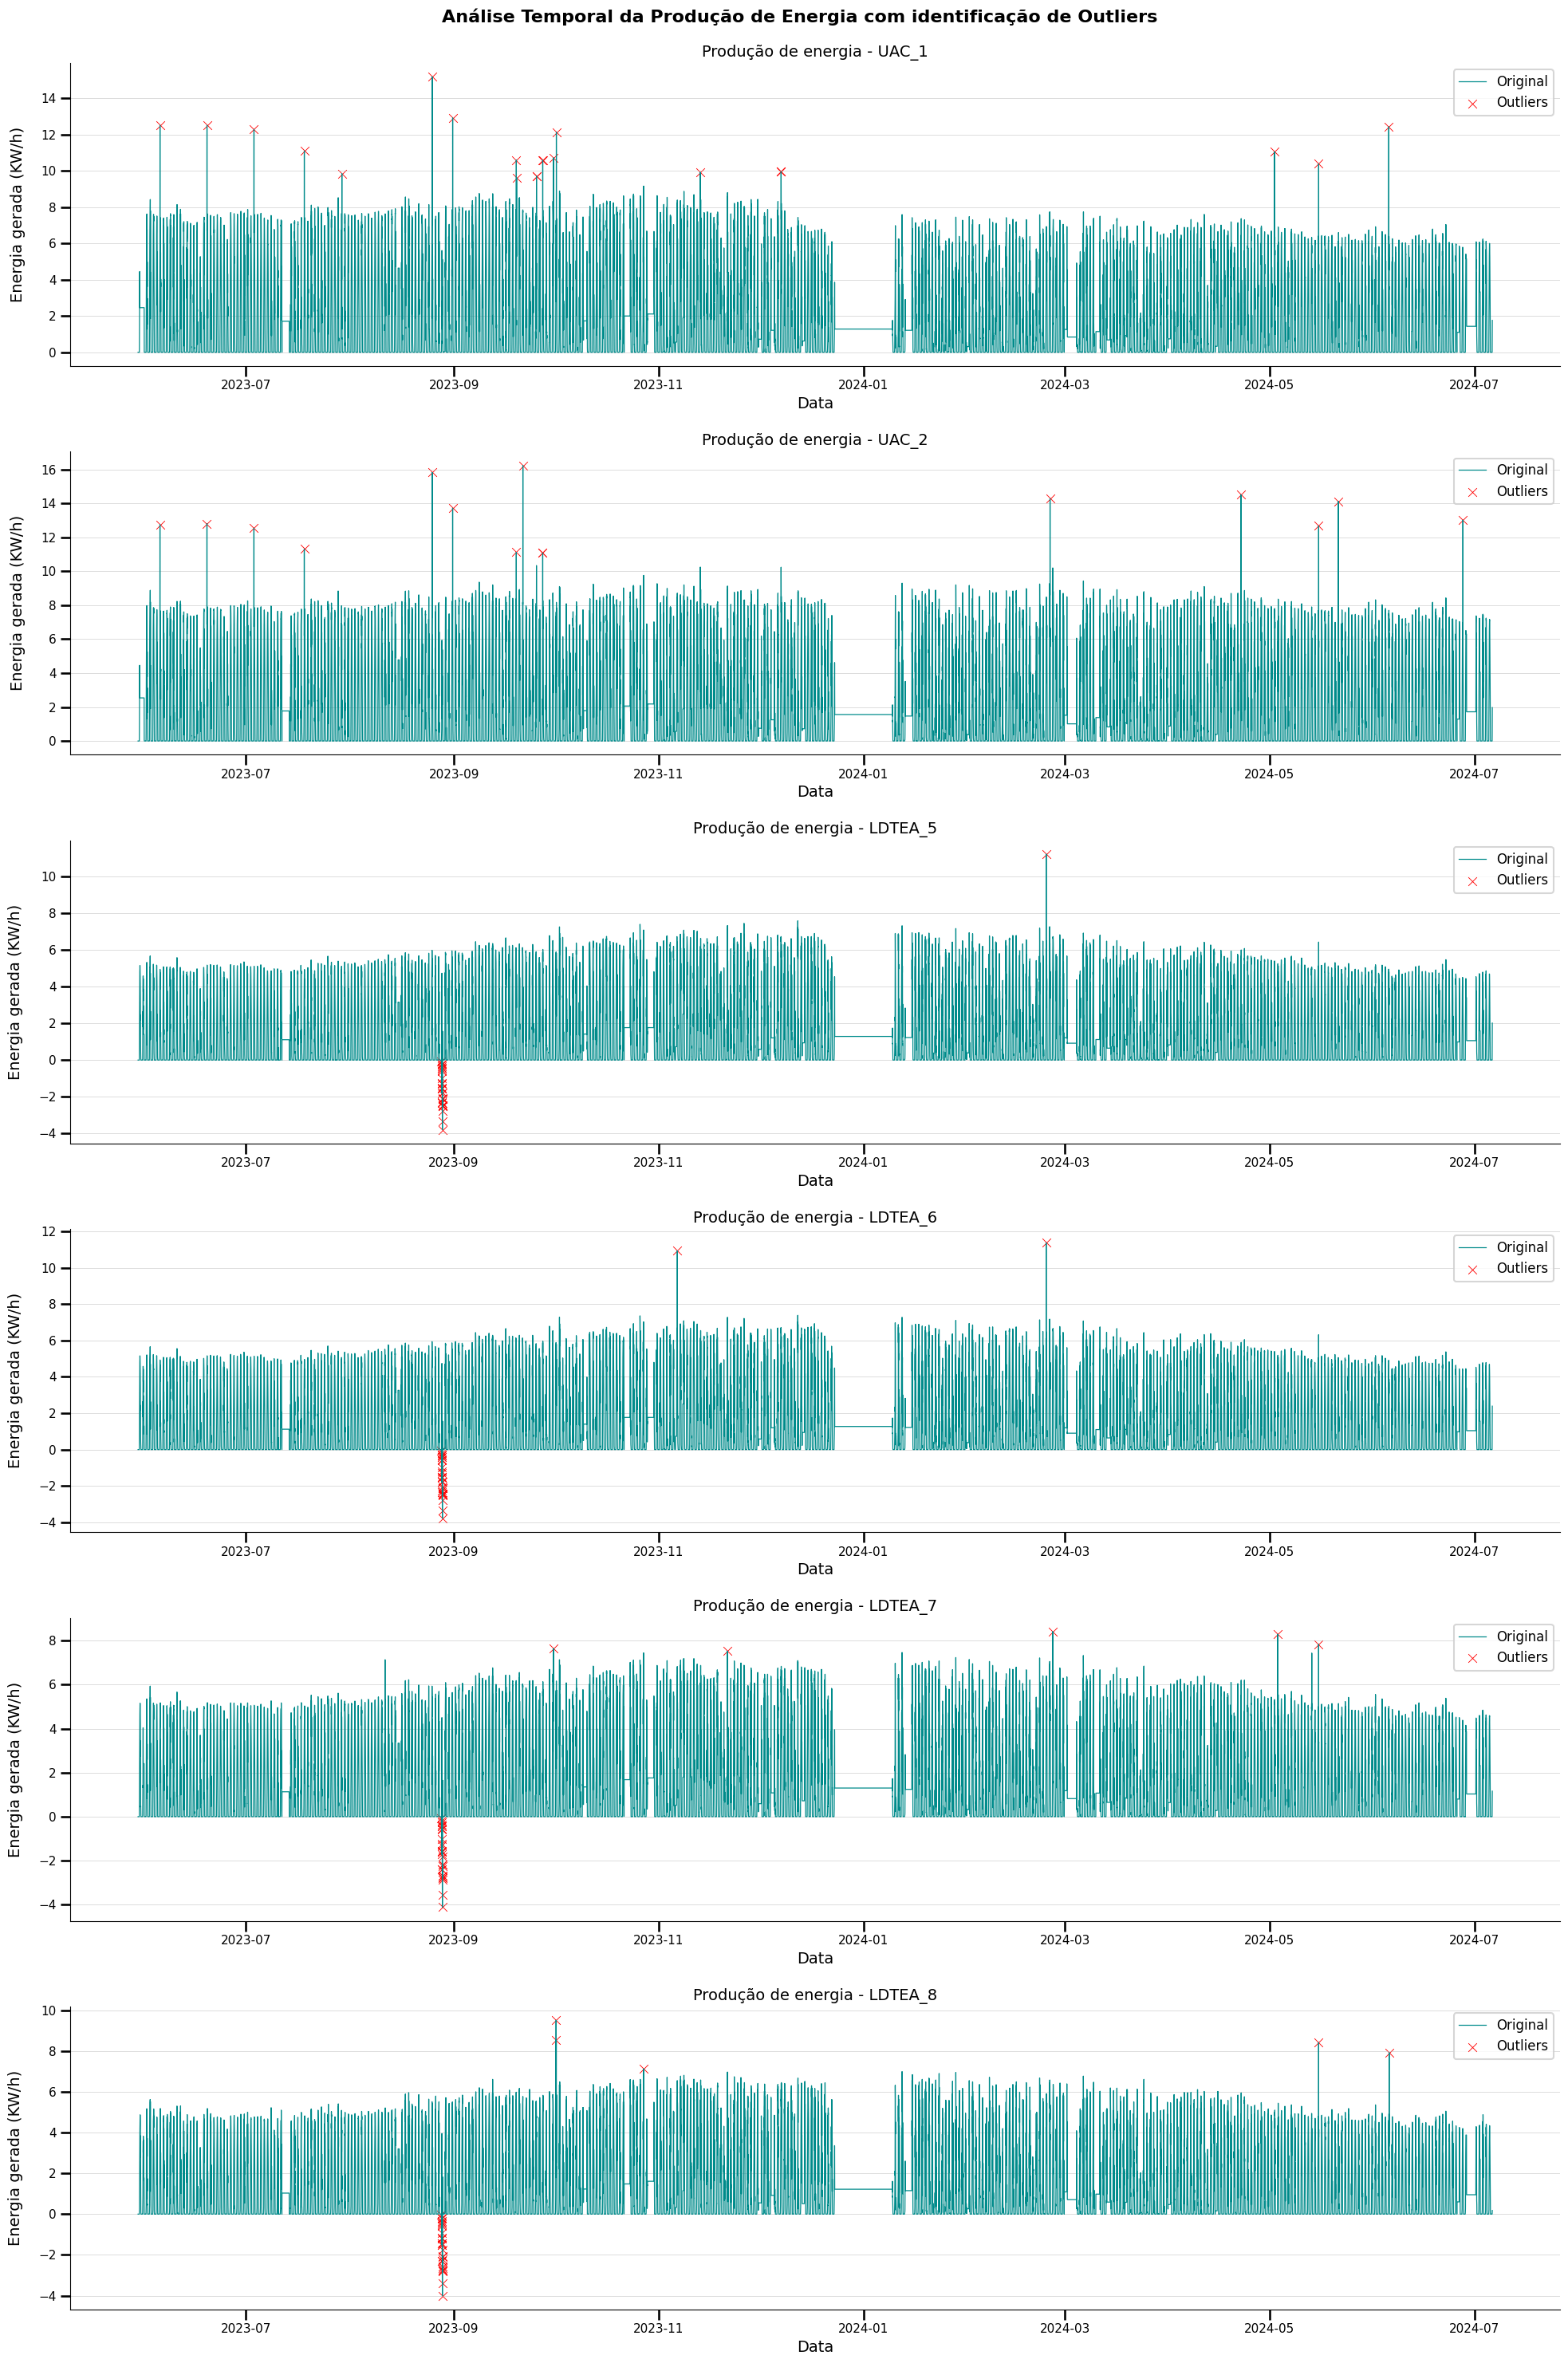

In [47]:
# plotar dataframe de outliers

target_columns = ["UAC_1", "UAC_2", "LDTEA_5", "LDTEA_6", "LDTEA_7", "LDTEA_8"]

fig, axes = plt.subplots(len(target_columns), figsize=(20, 5 * len(target_columns)))
for idx, col in enumerate(target_columns):
    sns.lineplot(
        data=praw_df,
        x=praw_df.index,
        y=col,
        ax=axes[idx],
        color=dark_cyan,
        label="Original",
        lw=0.9,
    )

    sns.scatterplot(
        data=poutliers_df,
        x=poutliers_df.index,
        y=col,
        ax=axes[idx],
        color="red",
        label="Outliers",
        marker="x",
        s=60,
    )

    axes[idx].set_title(f"Produção de energia - {col}", fontsize=14)
    axes[idx].set_xlabel("Data", fontsize=14)
    axes[idx].set_ylabel("Energia gerada (KW/h)", fontsize=14, labelpad=14)
    axes[idx].legend(fontsize=12)
    axes[idx].grid(axis="y", alpha=0.5, linewidth=0.6)
    axes[idx].spines["top"].set_visible(False)
    axes[idx].spines["right"].set_visible(False)
    axes[idx].spines["left"].set_linewidth(0.8)
    axes[idx].spines["bottom"].set_linewidth(0.8)
    axes[idx].tick_params(axis="x", labelsize=11)
    axes[idx].tick_params(axis="y", labelsize=11)

fig.suptitle(
    "Análise Temporal da Produção de Energia com identificação de Outliers",
    fontsize=16,
    fontweight="bold",
    x=0.51,
    y=0.99,
)
plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
if SAVE_FIGURE:
    plt.savefig(
        "../figures/data_preparation/0.6_temporal_analysis_outliers.pdf",
        dpi=300,
        bbox_inches="tight",
        # transparent=True,
    )
plt.show()

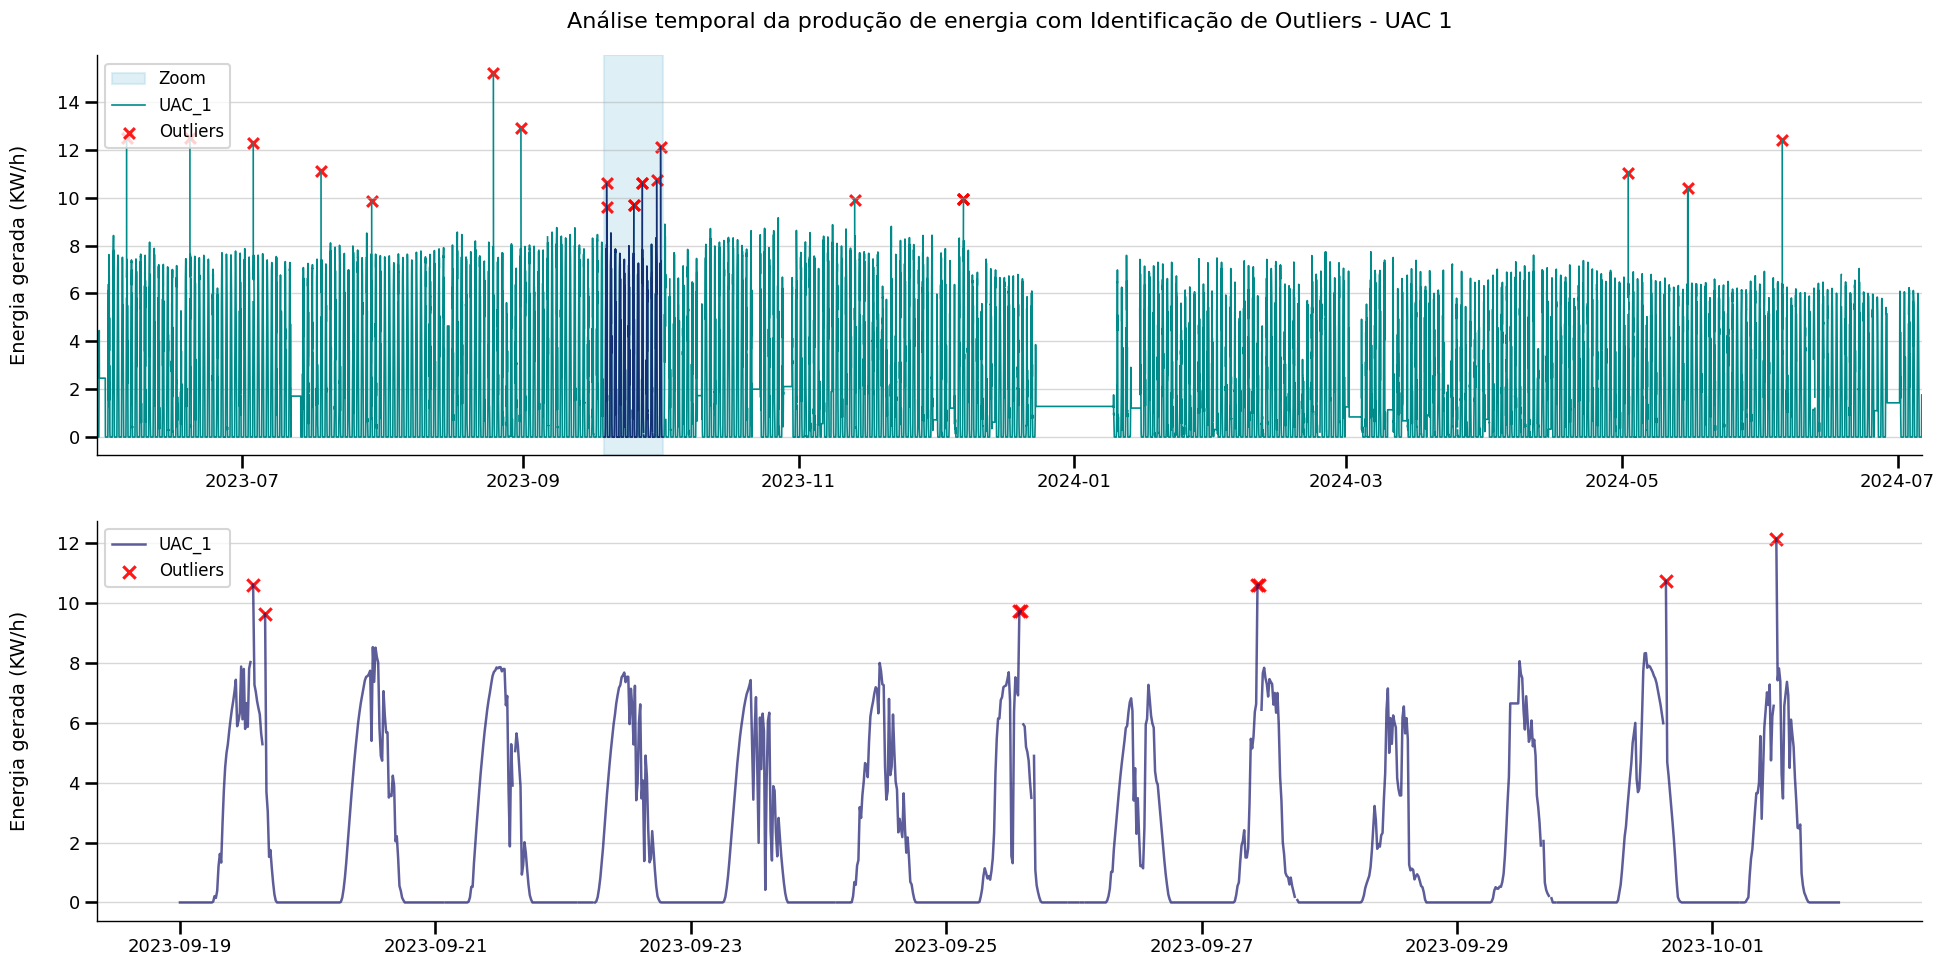

In [48]:
start_date = "2023-09-19"
end_date = "2023-10-01"
transductor = "UAC_1"

outliers_data = poutliers_df[transductor].dropna()
filtered_df = praw_df.loc[start_date:end_date, [transductor]]

fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].axvspan(
    filtered_df.index[0],
    filtered_df.index[-1],
    color="lightblue",
    alpha=0.4,
    label="Zoom",
)

axes[0].plot(
    praw_df.index,
    praw_df[transductor],
    color=dark_cyan,
    linewidth=1.2,
    label=transductor,
)

axes[0].plot(
    filtered_df.index,
    filtered_df,
    color="midnightblue",
    linewidth=1.2,
    alpha=0.8,
)

axes[0].scatter(
    outliers_data.index, 
    outliers_data, 
    label='Outliers', 
    color="red",
    marker="x",
    s=60,
    alpha=0.9,
)

axes[0].set_xlim(praw_df.index[0], praw_df.index[-1])
axes[0].tick_params(axis="x", labelsize=13)
axes[0].tick_params(axis="y", labelsize=13)
axes[0].set_title("Análise temporal da produção de energia com Identificação de Outliers - UAC 1", fontsize=16, pad=20,)
axes[0].set_ylabel("Energia gerada (KW/h)", fontsize=14, labelpad=20)
axes[0].legend(fontsize=12, loc="upper left")

fig.subplots_adjust(hspace=1.5)
axes[1].plot(
    filtered_df.index,
    filtered_df,
    color="midnightblue",
    linewidth=1.8,
    label=transductor,
    alpha=0.7,
)

axes[1].scatter(
    outliers_data.loc[filtered_df.index[0]:filtered_df.index[-1]].index,
    outliers_data.loc[filtered_df.index[0]:filtered_df.index[-1]], 
    label='Outliers', 
    color="red",
    marker="x",
    s=80,
    alpha=0.9,
)

axes[1].tick_params(axis="x", labelsize=13)
axes[1].tick_params(axis="y", labelsize=13)

start_date_str = filtered_df.index[0].strftime("%Y-%m-%d")
end_date_str = filtered_df.index[-1].strftime("%Y-%m-%d")
axes[1].set_ylabel("Energia gerada (KW/h)", fontsize=14, labelpad=20)

axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].spines["left"].set_linewidth(1)
axes[0].spines["bottom"].set_linewidth(1)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
axes[1].spines["left"].set_linewidth(1)
axes[1].spines["bottom"].set_linewidth(1)
axes[1].legend(fontsize=12, loc="upper left")

axes[0].grid(axis="y", alpha=0.5, linewidth=1)
axes[1].grid(axis="y", alpha=0.5, linewidth=1)

plt.tight_layout()
if SAVE_FIGURE:
    plt.savefig(
        "../figures/data_preparation/0.6_temporal_analysis_outliers_uac1_zoom.pdf",
        dpi=300,
        bbox_inches="tight",
        # transparent=True,
    )
plt.show()

In [49]:
# Detectando valores ausentes ou nulos (missing values)

for building in base_df.columns:
    n_missing = base_df[building].isnull().sum()
    print(f"{building.upper()}:  ({base_df[building].shape[0]} rows)") 
    print(f"Number of data points missing: {n_missing}")
    print(f"Proportion of dataset missing: {n_missing/len(base_df):.2%}\n")


LDTEA_5:  (38733 rows)
Number of data points missing: 84
Proportion of dataset missing: 0.22%

LDTEA_6:  (38733 rows)
Number of data points missing: 85
Proportion of dataset missing: 0.22%

LDTEA_7:  (38733 rows)
Number of data points missing: 93
Proportion of dataset missing: 0.24%

LDTEA_8:  (38733 rows)
Number of data points missing: 94
Proportion of dataset missing: 0.24%

UAC_1:  (38733 rows)
Number of data points missing: 119
Proportion of dataset missing: 0.31%

UAC_2:  (38733 rows)
Number of data points missing: 115
Proportion of dataset missing: 0.30%



In [50]:
# Verificar se o índice do DataFrame base_df está estritamente em ordem crescente e se os dados são equidistantes

order = base_df.index.is_monotonic_increasing
time_diffs = base_df.index.to_series().diff()
equidistant = time_diffs.nunique() == 1

display(time_diffs[:3])
print(f"Order: {order}")
print(f"Equidistant: {equidistant}")

date_time
2023-05-29 21:15:00-03:00               NaT
2023-05-29 21:30:00-03:00   0 days 00:15:00
2023-05-29 21:45:00-03:00   0 days 00:15:00
Freq: 15T, Name: date_time, dtype: timedelta64[ns]

Order: True
Equidistant: True


----
Interpolar - Missing Values


O número de valores ausentes ou nulos é relativamente pequeno e a série temporal possui uma frequência regular, com isso os métodos de interpolação como interpolação linear ou spline podem ser usados ​​para estimar o ausente valores. Portanto, interaremos linearmente os valores da NAN

In [51]:
df_il = base_df.interpolate(method="linear")
df_it = base_df.interpolate(method="time")
df_is = base_df.interpolate(method="spline", order=3)
df_ff = base_df.fillna(method="ffill")

df_imputed = df_il.copy()

for building in df_imputed.columns:
    n_missing = df_imputed[building].isnull().sum()
    print(f"\n{building.upper()}:")
    print(f"Number of data points missing: {n_missing}")
    print(f"Proportion of data missing: {n_missing/len(df_imputed):.2%}")


LDTEA_5:
Number of data points missing: 2
Proportion of data missing: 0.01%

LDTEA_6:
Number of data points missing: 2
Proportion of data missing: 0.01%

LDTEA_7:
Number of data points missing: 2
Proportion of data missing: 0.01%

LDTEA_8:
Number of data points missing: 2
Proportion of data missing: 0.01%

UAC_1:
Number of data points missing: 0
Proportion of data missing: 0.00%

UAC_2:
Number of data points missing: 1
Proportion of data missing: 0.00%


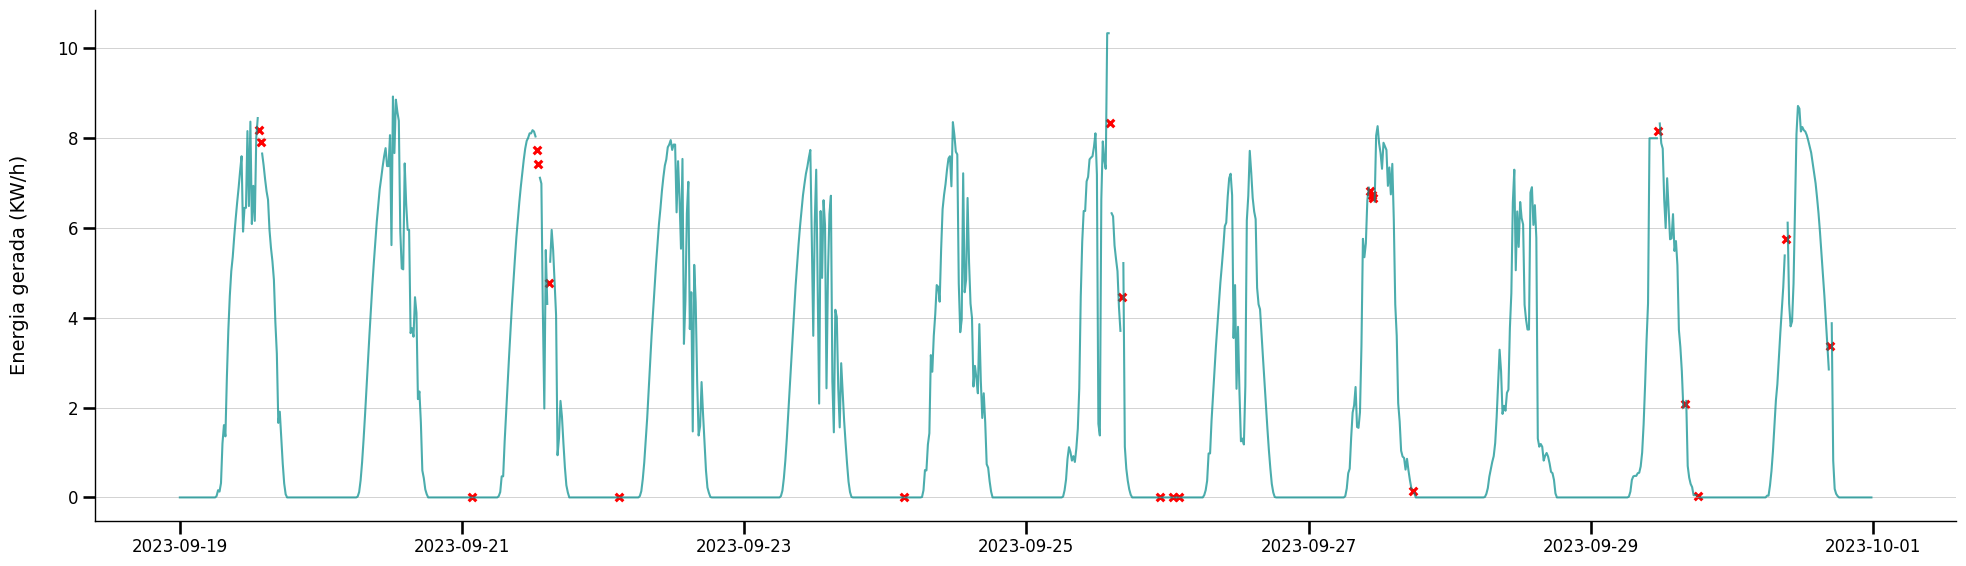

In [52]:
start_date = "2023-09-19"
end_date = "2023-09-30"
# start_date = "2023-06-01"
# end_date = "2024-06-01"
transductor = "UAC_2"

filtered_base_df = base_df.loc[start_date:end_date, [transductor]]
filtered_imputed_df = df_imputed.loc[start_date:end_date, [transductor]]
interpolated_values = filtered_imputed_df.loc[filtered_base_df[transductor].isnull()]

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(
    filtered_base_df.index, 
    filtered_base_df, 
    label=transductor.upper(), 
    lw=1.5, 
    color=dark_cyan,
    alpha=0.7,
)

ax.scatter(
    interpolated_values.index,
    interpolated_values,
    label="Valores ausentes",
    color="red",
    marker="x",
    s=30,
)

# ax.set_title("", fontsize=14, fontweight="bold")
ax.set_ylabel("Energia gerada (KW/h)", fontsize=14, labelpad=20)
ax.set_xlabel("")

ax.tick_params(axis="x", labelsize=12, rotation=0)
ax.tick_params(axis="y", labelsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)
ax.grid(axis="y", lw=0.4)

plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
if SAVE_FIGURE:
    plt.savefig(
        "../figures/data_preparation/0.6_temporal_analysis_missing_values_uac2.pdf",
        dpi=300,
        bbox_inches="tight",
        # transparent=True,
    )
plt.show()



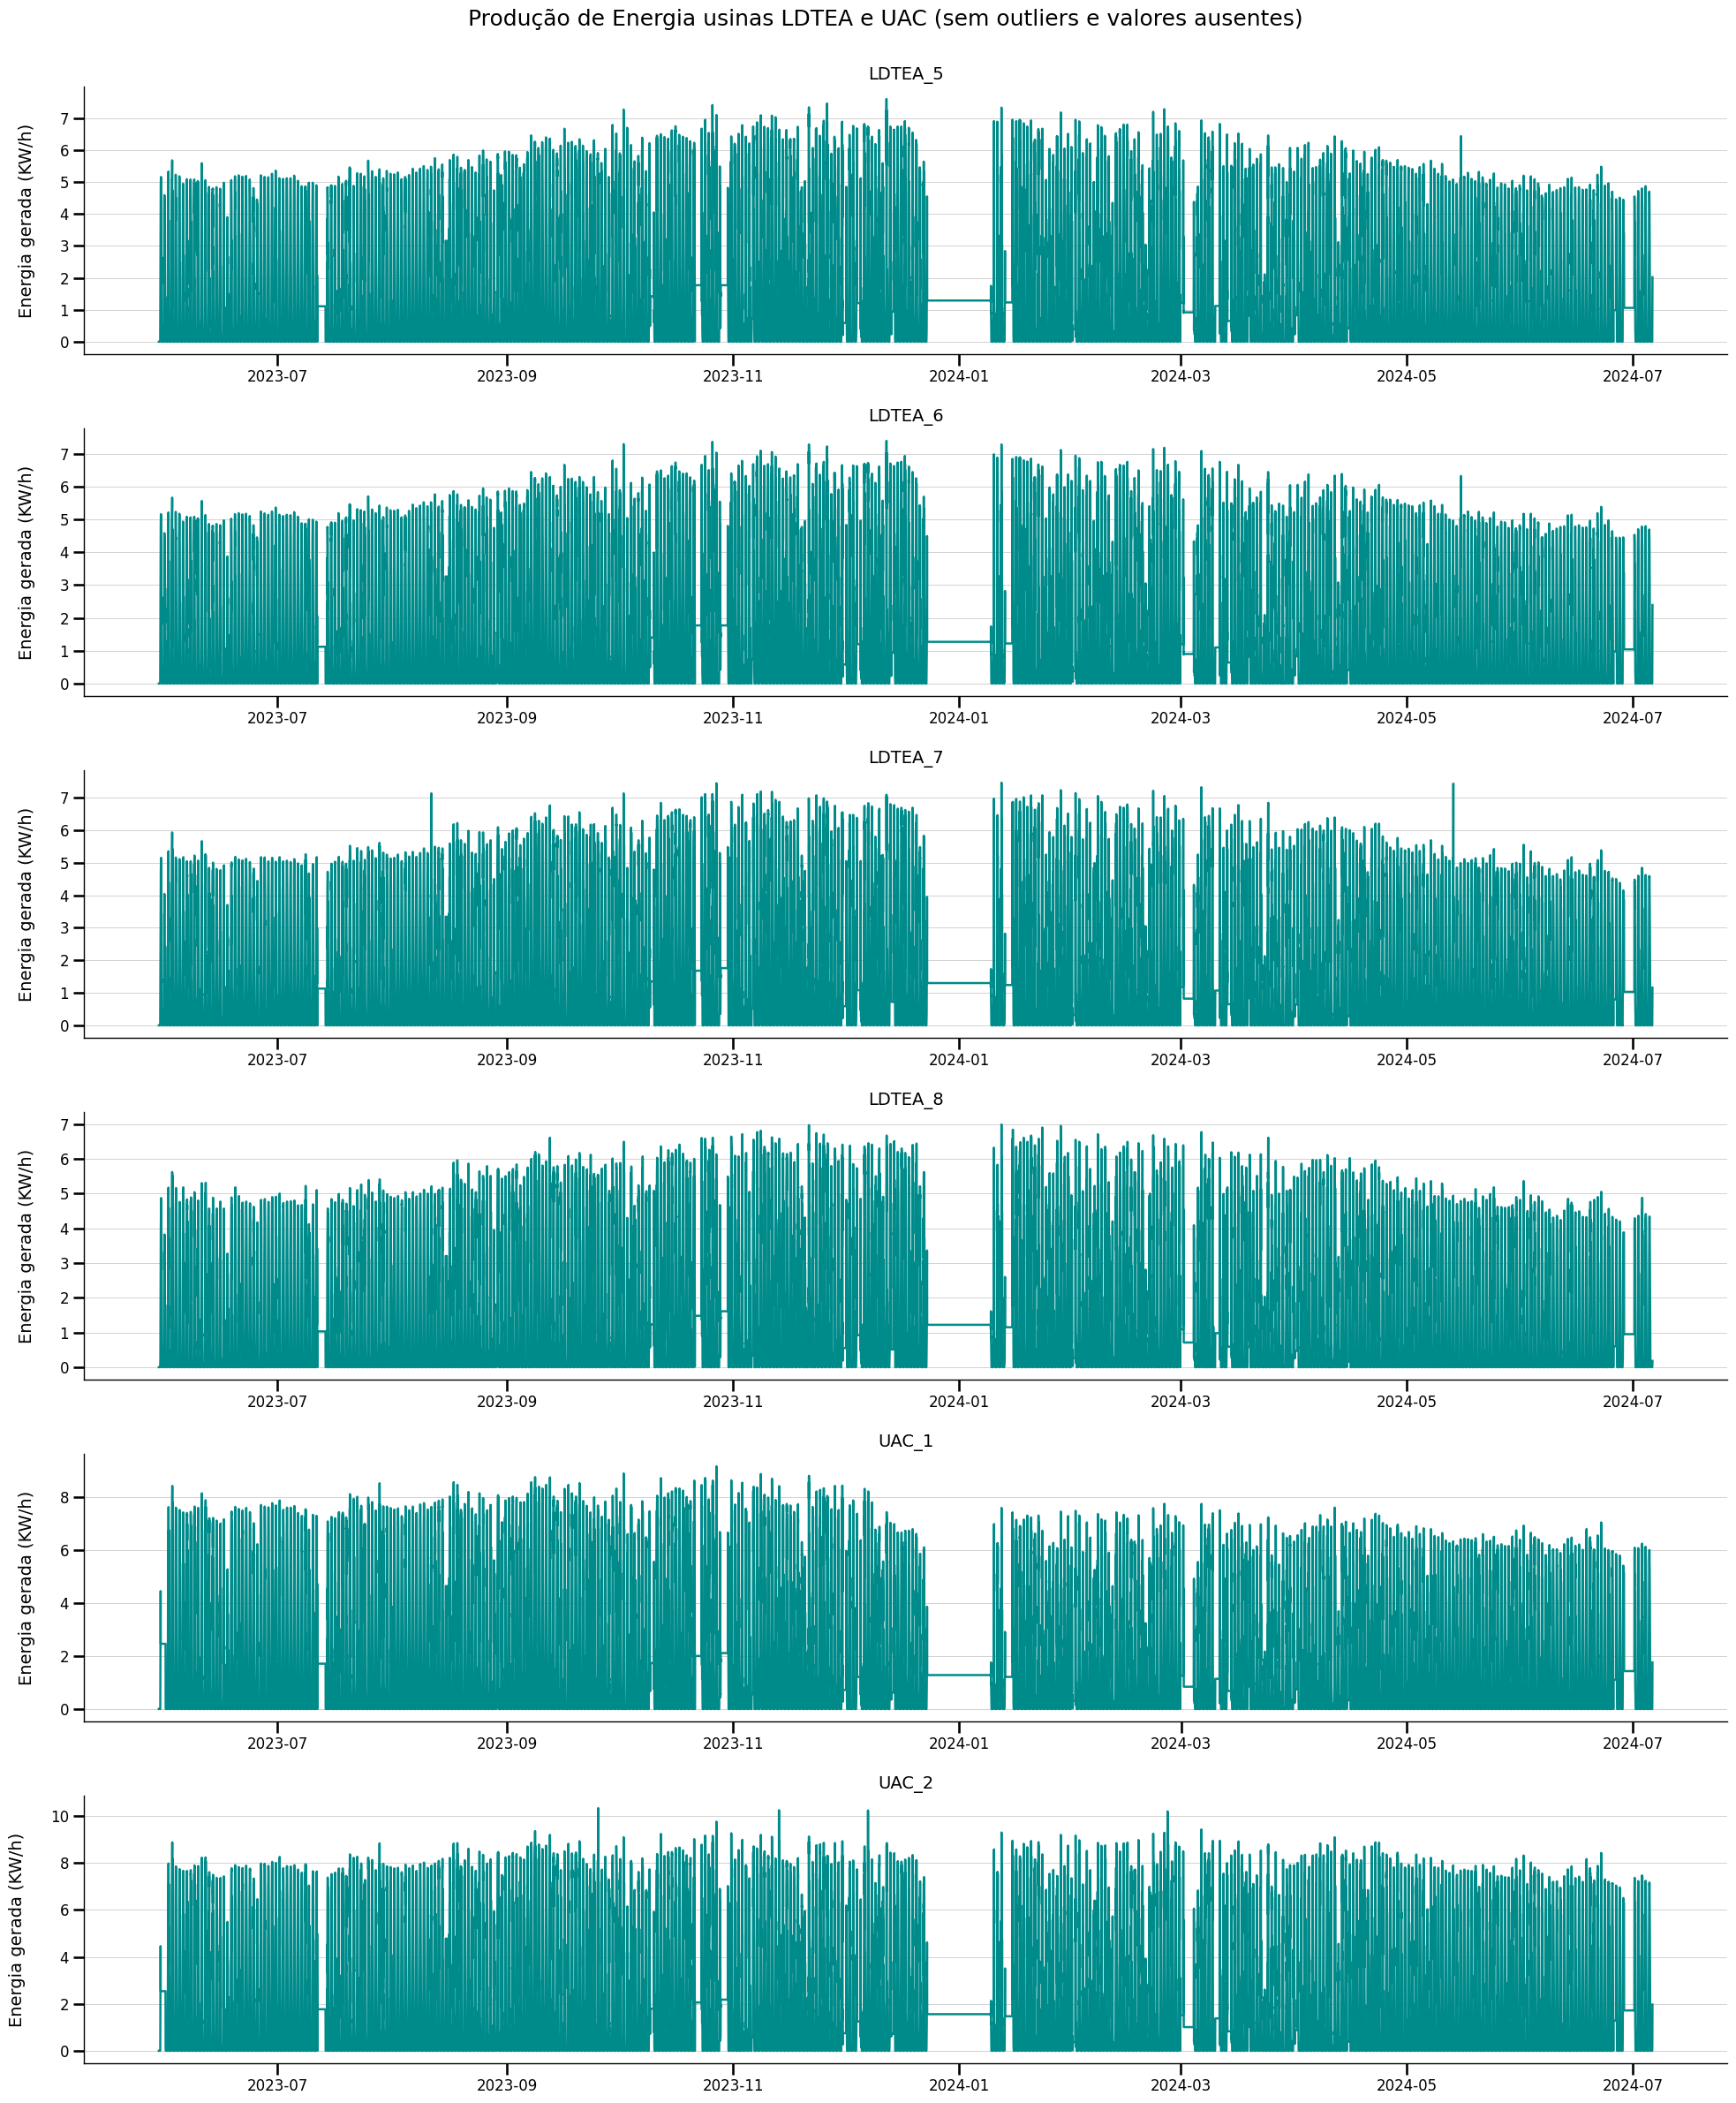

In [53]:
num_columns = len(df_imputed.columns)

fig, axes = plt.subplots(num_columns, 1, figsize=(20, 4 * num_columns))
if num_columns == 1:
    axes = [axes]

for ax, column in zip(axes, df_imputed.columns):
    ax.plot(df_imputed.index, df_imputed[column], label=column.upper(), lw=1.8, color=dark_cyan)
    ax.set_title(column, fontsize=14)
    ax.set_ylabel("Energia gerada (KW/h)", fontsize=14, labelpad=20)

    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1)
    ax.spines["bottom"].set_linewidth(1)
    ax.grid(axis="y", lw=0.4)

fig.suptitle(
    "Produção de Energia usinas LDTEA e UAC (sem outliers e valores ausentes)",
    fontsize=18,
    x=0.51,
    y=0.995,
)

plt.tight_layout()
if SAVE_FIGURE:
    plt.savefig(
        "../figures/data_preparation/0.6_temporal_analysis_no_outliers_no_missing_values.pdf",
        dpi=300,
        bbox_inches="tight",
        # transparent=True,
    )
plt.show()

In [54]:
# Salvando os dados em arquivos CSV

_df_imputed = df_imputed.copy()
df_save = _df_imputed.loc[START_DATE:END_DATE]
df_save.to_csv("../data/clean/0.0_production_sige_pt15m.csv")

# Dados agregados no inicio da hora em que foram efetivamente coletados
# Um registro às 12:00 (representando 12:15 a 13:00) 
df_hourly = align_resample(df_imputed, "H")
df_hourly = df_hourly.loc[START_DATE:END_DATE]
df_hourly.to_csv("../data/clean/0.0_production_sige_p60m.csv")

# Total diário de geração de energia (KW/h/dia)
df_daily = df_hourly.resample('D').sum()
df_daily.to_csv("../data/clean/0.0_production_sige_p1d.csv")

# Media diária de geração de energia por mês (KW/h/mês)
avg_monthly = df_daily.resample('M').mean().round(2)
avg_monthly.index = avg_monthly.index.to_period('M')
avg_monthly.to_csv("../data/clean/0.0_production_sige_p1m.csv")